# Marriage Trends Across Poland

The client was interested in understanding how marriage trends in her country have changed.  

As is being noticed across much of the developed world, marriage rates have been declining and often celebrated later in life. Does this trend also exist with in Poland and how does it compare to the rest of Europe? 

For our clients we will focus on the general trend of marriages of young to middle age adults ,using the  crude marriage rate for the nation, the average age at time of marriage and the popularity of marriage at different age groups for both men and women.


## Data Sources
Our data is pulled form two sources: 
1. [Eurostat](https://ec.europa.eu/eurostat/web/main/home) - Provides and harmonzes statisitcs across member states of the European Union
2. [BDL](https://bdl.stat.gov.pl/bdl/start) - The Local Data Bank (BDL) is Poland's largest database for national metrics

For ease the data related to *crude marriage rate*, *ave age of first marriage*, and *marriage by age group* is stored in .csv files.

## Loading the Data

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter

from IPython.core.display import HTML


In [32]:
df_female = pd.read_csv('data/bride age group.csv', sep=';')
df_male = pd.read_csv('data/groom age group.csv', sep=';')
df_total_marriages = pd.read_csv('data/marriages_contracted_per_year.csv', sep=';')
# df_pop = pd.read_csv('data/poland_population.csv', sep=';') 
df_pop = pd.read_csv('data/poland_population_2005.csv', sep=';') 
# df_eu_cmr = pd.read_csv('data/tps00206 EU and Poland Crude Marraige Rate.csv')
df_eu_cmr = pd.read_csv('data/tps00206 EU CMR 2001.csv')
# df_ama_female = pd.read_csv('data/tps00014 Mean Female Age at Marriage.csv')
# df_ama_male = pd.read_csv('data/tps00014 Mean Male Age at Marriage.csv')
df_sing_age = pd.read_csv('data/poland_marriages_by_age_gender_year.csv')

plt.style.use('./executive_report.mplstyle')

### Explanation of Data Sources

__df_female and df_male__:  Contains the number of marriages contracted per age group per year for males and females. [BDL](https://bdl.stat.gov.pl/bdl/metadane/cechy/4040)

__df_pop__: The population of poland over time [BDL](https://bdl.stat.gov.pl/bdl/metadane/cechy/2462)

__df_eu_cmr__: The crude marraige rate of the European Union as a whole. Crude Marriage Rate (CMR) is the number of marriages contracted each year per 1000 people. [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/tps00206/)

<!-- __df_ama_female__ & __df_ama_male__ : The average age of men and women at the time of their first marraige. [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/tps00014/)
-->

### Data Wrangling

#### Marraiges by Age Group

For the first marriage by age data, we will need to add a column denoting the gender, as well as extract the age group from the Age of females and Age of males columns. Then drop all unnecessary columns. 

In [33]:
df_female['gender'] = 'female'
df_male['gender'] = 'male'

# Dropping the rows representing total marriages regardless of age group 
df_female = df_female[df_female['Age of females'] != 'females total']
df_male = df_male[df_male['Age of males'] != 'males total']

# Drop female and male columns
df_female.drop(columns='Age of males', inplace=True)
df_male.drop(columns='Age of females', inplace=True)

# rename to age group
df_female.rename(columns={'Age of females' : 'age group'}, inplace=True)
df_male.rename(columns={'Age of males' : 'age group'}, inplace=True)

# print(df_female.head())
# print(df_male.head())

In [34]:
df_marriage = pd.concat([df_male, df_female], axis=0)
df_marriage.drop(
    columns=['Code','Name', 'Location', 'Types of marriages', 'Measure Unit', 'Attribute', 'Unnamed: 10'],
    inplace=True)

del(df_female, df_male)
df_marriage.head(5)

,age group,Year,Value,gender
14,under 20 years,2010,1320,male
15,under 20 years,2011,1090,male
16,under 20 years,2012,911,male
17,under 20 years,2013,716,male
18,under 20 years,2014,619,male


For our clients needs, we will aggregate data when the age group is of 40 years of more, as they are focused on the marriage trends of early to middle adulthood.

In [35]:
new_age_dict = {
    'under 20 years' : '<20',
    '40-49' : '+40',
    '50-59' : '+40',
    '60 and more' : '+40'
}

df_marriage['age group'].replace(new_age_dict, inplace= True)
df_marriage = df_marriage.groupby(['Year', 'gender', 'age group'])['Value'].sum().reset_index()

df_marriage.head(6)

,Year,gender,age group,Value
0,2010,female,+40,13816
1,2010,female,20-24,79746
2,2010,female,25-29,89646
3,2010,female,30-34,26972
4,2010,female,35-39,9150
5,2010,female,<20,9007


We shall also compute the % of the total of marriages that each age group contributes each year. We will also add the rank, to indicate the order which age group contributes the most per year.

In [36]:
# df_marriage['yearly total'] = df_marriage.groupby(['Year','gender'])['Value'].transform('sum')
df_marriage['% of total'] = df_marriage['Value'] / df_marriage.groupby(['Year','gender'])['Value'].transform('sum')
df_marriage['rank'] = df_marriage.groupby(['Year','gender'])['Value'].rank(ascending=False)
df_marriage.head(12)


,Year,gender,age group,Value,% of total,rank
0,2010,female,+40,13816,0.060507,4.0
1,2010,female,20-24,79746,0.349247,2.0
2,2010,female,25-29,89646,0.392604,1.0
3,2010,female,30-34,26972,0.118124,3.0
4,2010,female,35-39,9150,0.040072,5.0
5,2010,female,<20,9007,0.039446,6.0
6,2010,male,+40,20041,0.087769,4.0
7,2010,male,20-24,44683,0.195689,2.0
8,2010,male,25-29,103417,0.452914,1.0
9,2010,male,30-34,44104,0.193153,3.0


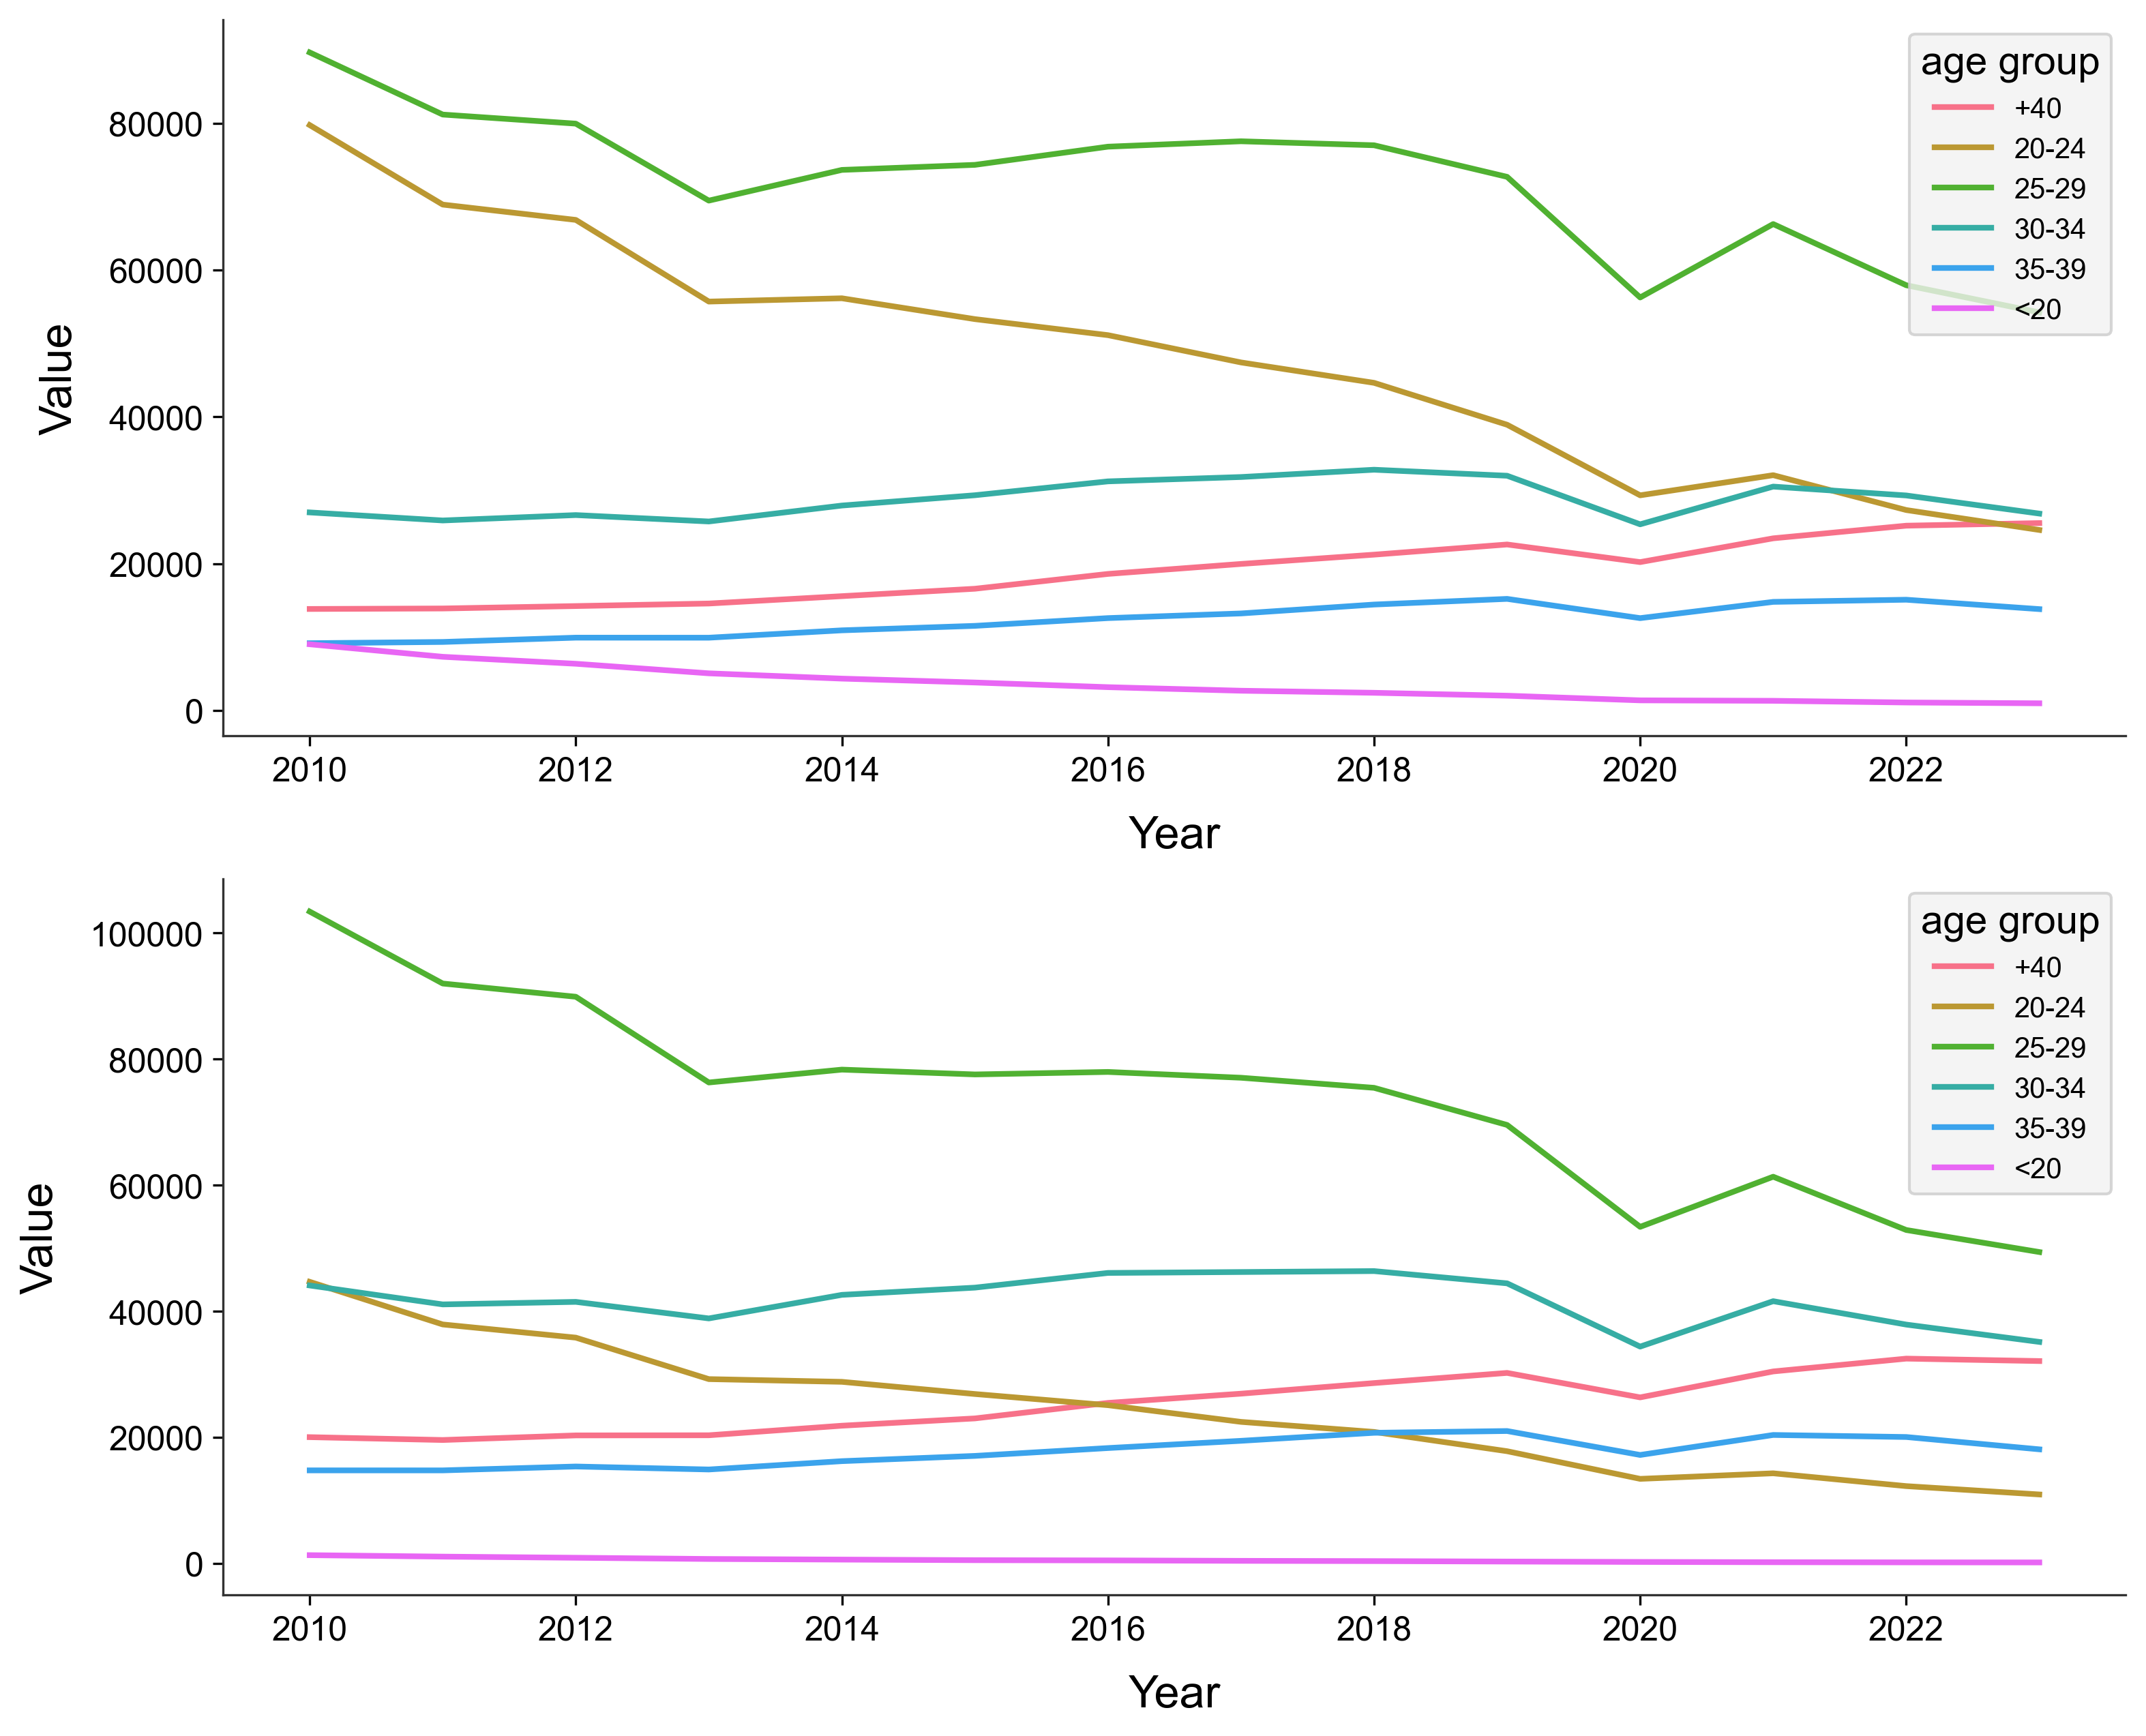

<Figure size 3000x2400 with 0 Axes>

In [37]:
figure, axes = plt.subplots(2,1)
plt.figure(figsize=(10,8))

for i, gender in enumerate(df_marriage['gender'].unique()):
    dt_temp = df_marriage[df_marriage['gender'] == gender]
    sns.lineplot(dt_temp, x='Year', y='Value', ax=axes[i], hue='age group')

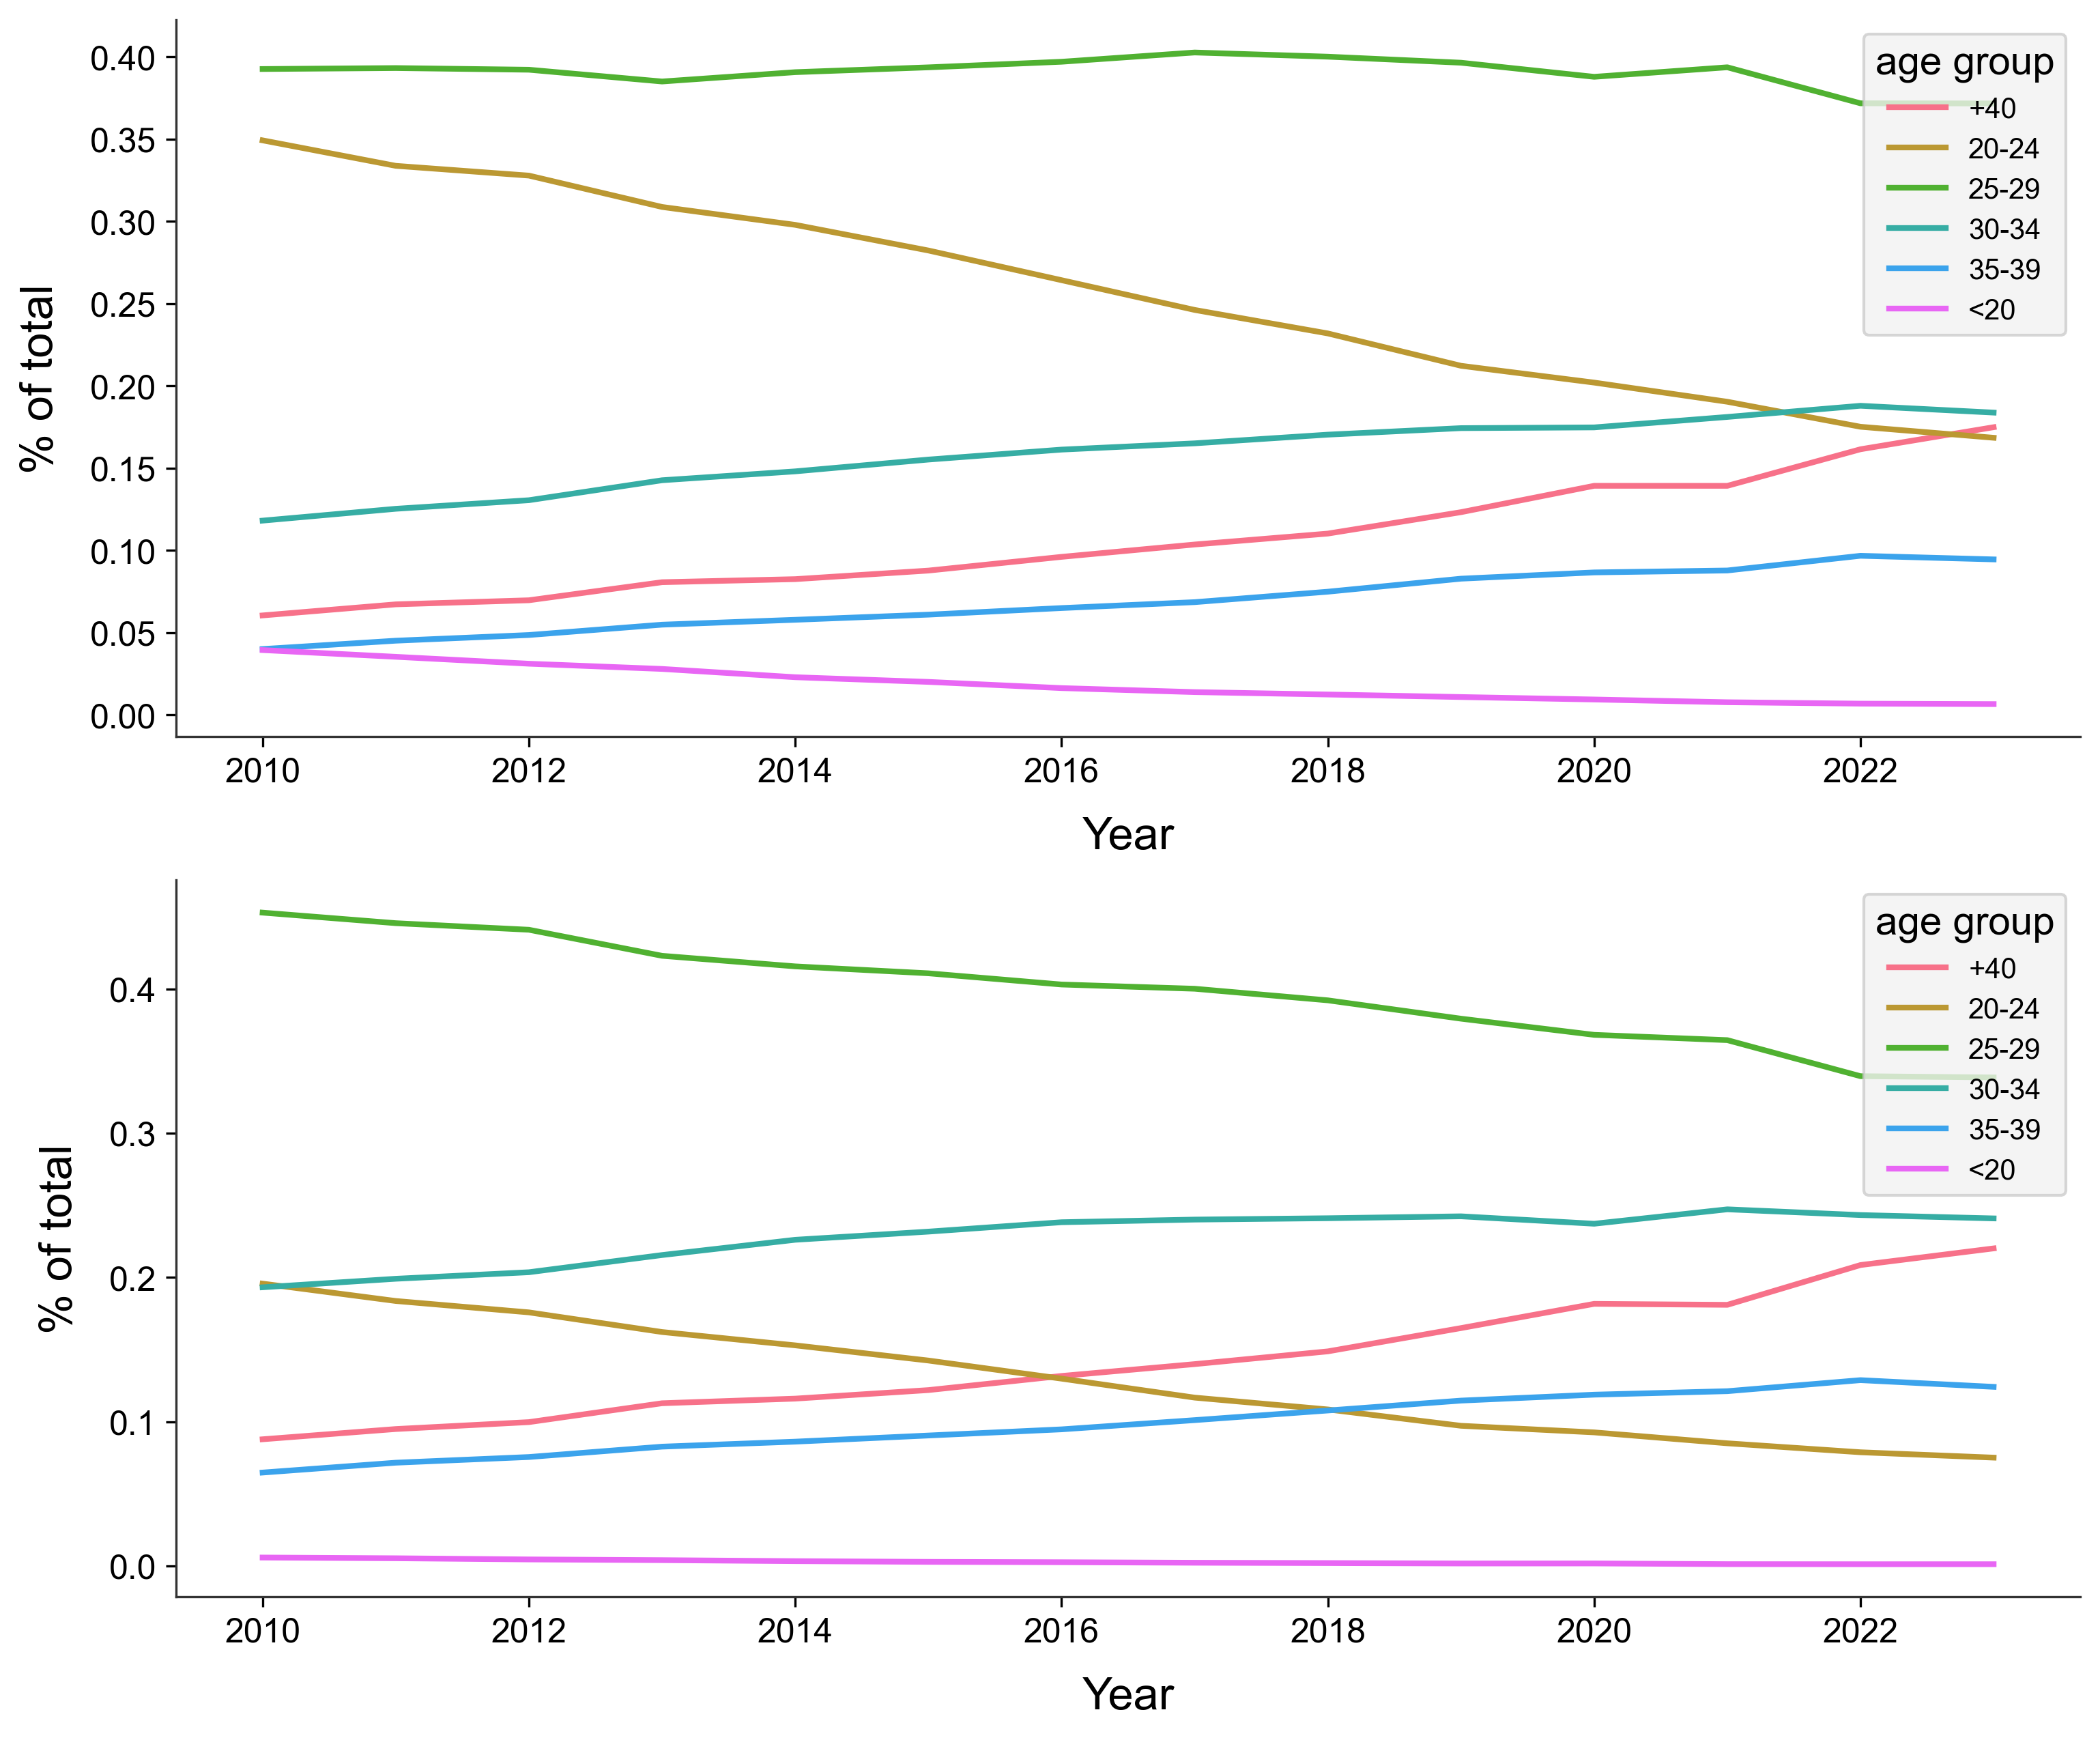

<Figure size 3000x2400 with 0 Axes>

In [38]:
figure, axes = plt.subplots(2,1)
plt.figure(figsize=(10,8))

for i, gender in enumerate(df_marriage['gender'].unique()):
    dt_temp = df_marriage[df_marriage['gender'] == gender]
    sns.lineplot(dt_temp, x='Year', y='% of total', ax=axes[i], hue='age group')

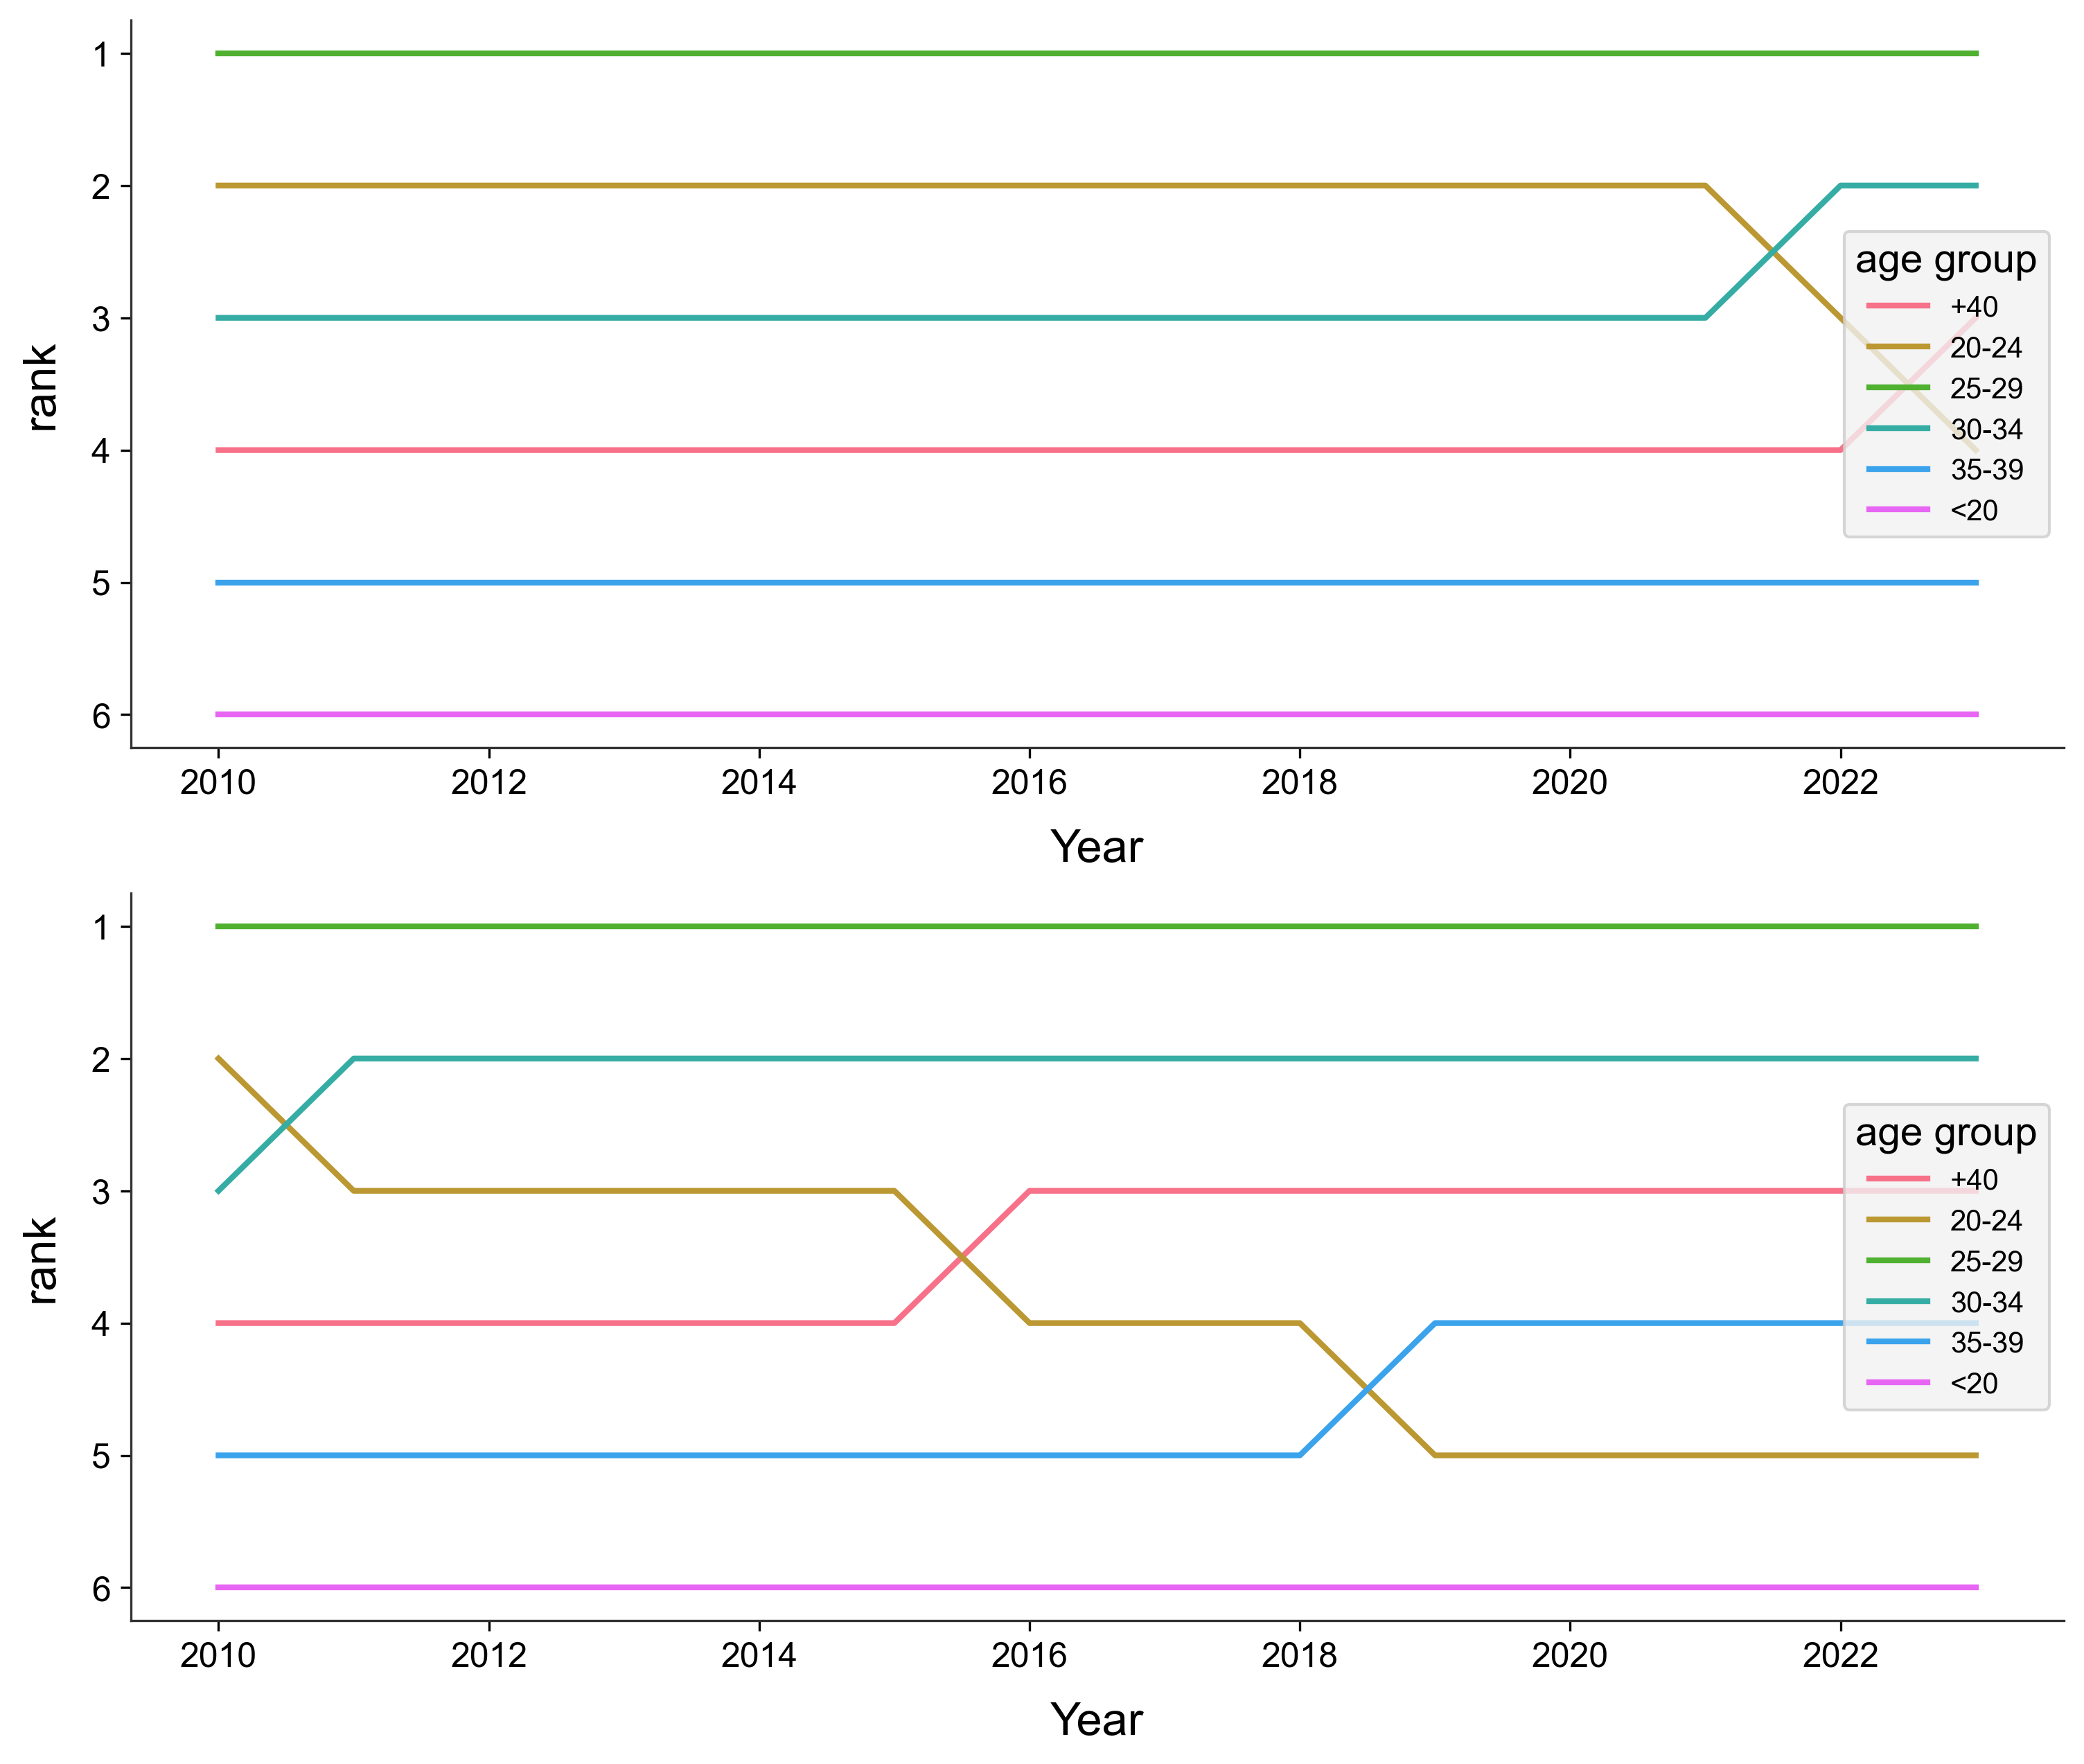

<Figure size 3000x2400 with 0 Axes>

In [39]:
figure, axes = plt.subplots(2,1)
plt.figure(figsize=(10,8))

for i, gender in enumerate(df_marriage['gender'].unique()):
    dt_temp = df_marriage[df_marriage['gender'] == gender]
    sns.lineplot(dt_temp, x='Year', y='rank', ax=axes[i], hue='age group')
    axes[i].invert_yaxis()  # Invert the y-axis for the specific axes


#### Total Marriages by Year

In [40]:
df_total_marriages.head(5)

,Code,Name,Location,Year,Value,Measure Unit,Attribute,Unnamed: 7
0,0,POLAND,total,1995,207081,-,M,NaN
1,0,POLAND,total,1996,203641,-,NaN,NaN
2,0,POLAND,total,1997,204850,-,NaN,NaN
3,0,POLAND,total,1998,209430,-,NaN,NaN
4,0,POLAND,total,1999,219398,-,NaN,NaN


In [41]:
df_total_marriages = df_total_marriages.loc[:, ['Year','Value']]
df_total_marriages.head(5)

,Year,Value
0,1995,207081
1,1996,203641
2,1997,204850
3,1998,209430
4,1999,219398


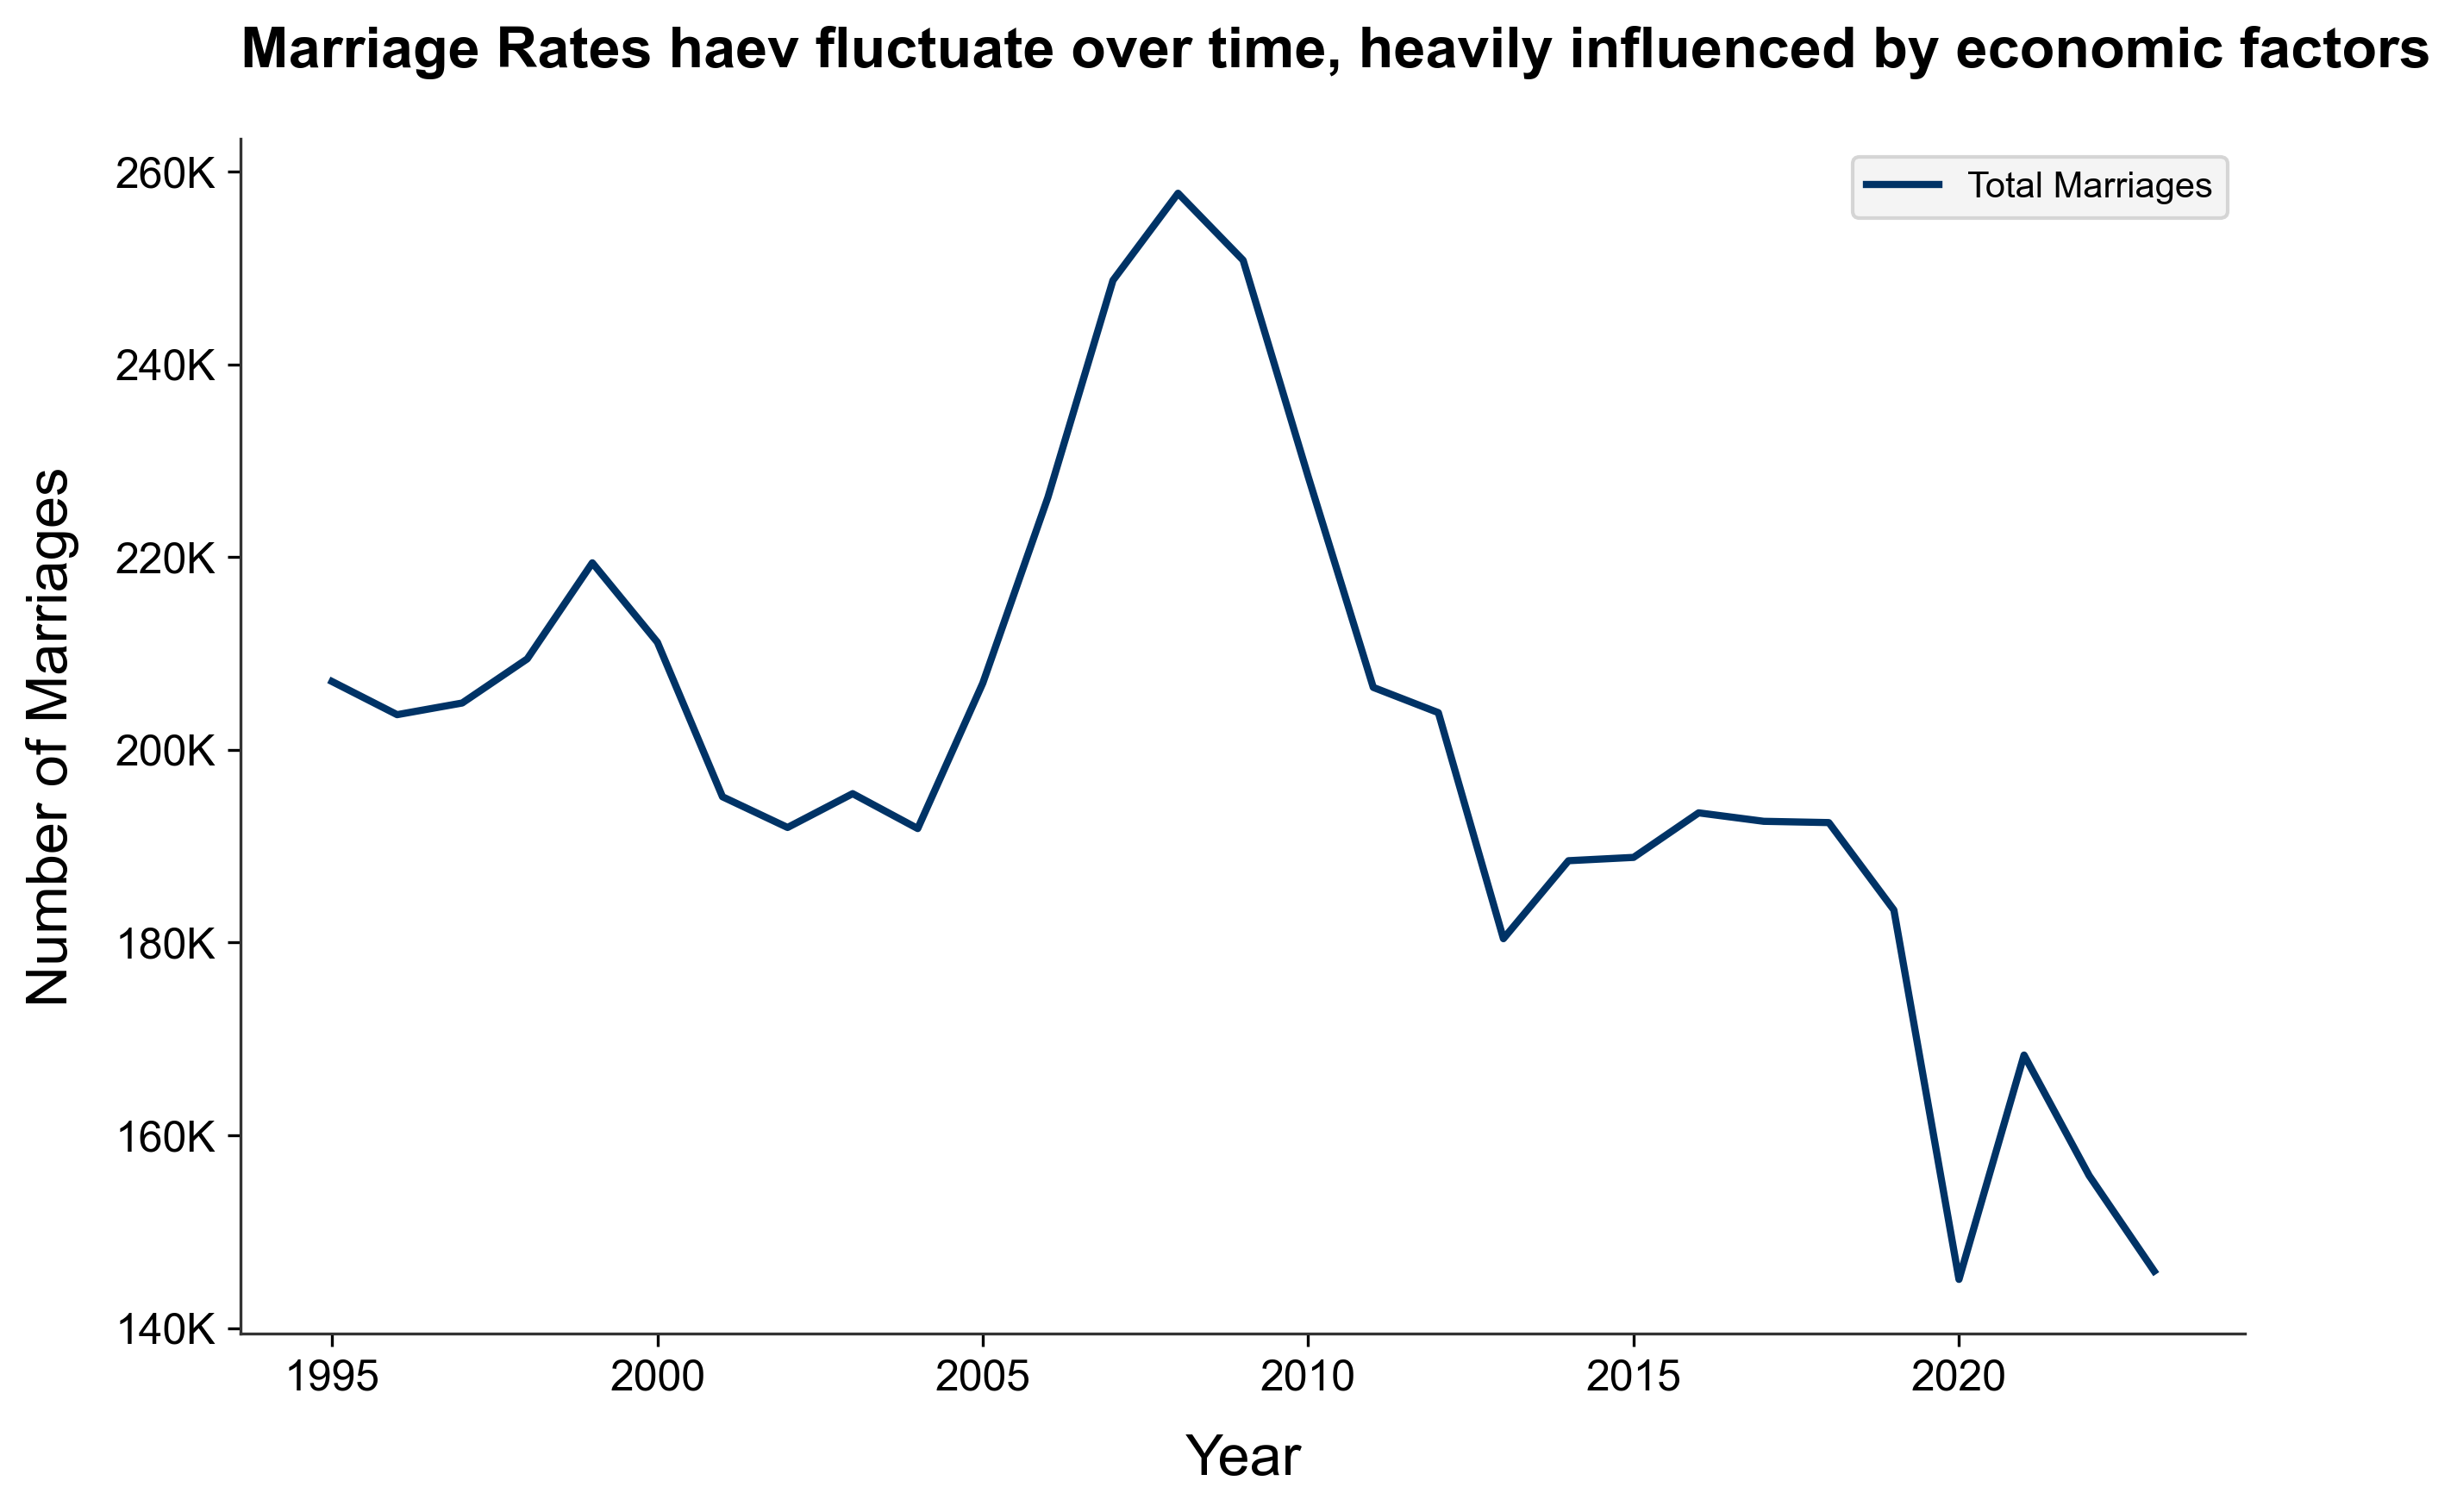

In [42]:

plt.figure(figsize=(10,6))

# ----- Axis Setup ----- #
ax1 = plt.gca()
# ax2 = ax1.twinx()

# ----- Plots ----- #
sns.lineplot(df_total_marriages, x='Year', y='Value', label='Total Marriages', ax=ax1)
# sns.lineplot(df_ama[df_ama['gender'] == 'male'], x ='year', y ='ave_age', label= 'Ave Age of Groom', ax=ax2, linestyle='--')
# sns.lineplot(df_ama[df_ama['gender'] == 'female'], x ='year', y ='ave_age',label= 'Ave Age of Bride', ax=ax2, linestyle=':')
# sns.lineplot(weighted_avg_df[weighted_avg_df['sex'] == 'M'], x ='TIME_PERIOD', y ='Weighted_Ave_Age', label= 'Ave Age of Groom', ax=ax2, linestyle='--')
# sns.lineplot(weighted_avg_df[weighted_avg_df['sex'] == 'F'], x ='TIME_PERIOD', y ='Weighted_Ave_Age', label= 'Ave Age of Bride', ax=ax2, linestyle=':')

# ----- Title Formatting ---- #
plt.title('Marriage Rates haev fluctuate over time, heavily influenced by economic factors', loc='left', ha='left')

# ----- Axis Formatting ----- #
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}K'.format(y/1000)))
ax1.set_ylabel(ylabel='Number of Marriages')
# ax2.set_ylabel(ylabel='Age of Marriage')

ax1.grid(False)
# ax2.grid(False)

# ----- Legend Formatting ----- #
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax2.get_legend().remove()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

plt.show()

#### Total Population

In [43]:
df_pop.head(5)

,Code,Name,Periods,Locations,Sex,Year,Value,Measure Unit,Attribute,Unnamed: 9
0,0,POLAND,year,total,total,2005,38157055.0,person,NaN,NaN
1,0,POLAND,year,total,total,2006,38125479.0,person,NaN,NaN
2,0,POLAND,year,total,total,2007,38115641.0,person,NaN,NaN
3,0,POLAND,year,total,total,2008,38135876.0,person,NaN,NaN
4,0,POLAND,year,total,total,2009,38167329.0,person,NaN,NaN


In [44]:
df_pop = df_pop[['Year', 'Value']].dropna(axis=0, how='any')
df_pop.head(5)

,Year,Value
0,2005,38157055.0
1,2006,38125479.0
2,2007,38115641.0
3,2008,38135876.0
4,2009,38167329.0


#### Crude Marraige Rate


In [45]:
# df_crude = pd.concat([df_total['Value'], df_pop], axis=1, )
df_cmr = pd.merge(df_total_marriages, df_pop, on='Year', how='outer')
df_cmr = df_cmr.dropna().reset_index(drop=True)
df_cmr.columns = ['year', 'marriages', 'population']
df_cmr['cmr'] = (df_cmr['marriages'] / df_cmr['population'] * 1000).round(1)
df_cmr.drop(columns=['marriages', 'population'], inplace=True)

df_cmr

,year,cmr
0,2005,5.4
1,2006,5.9
2,2007,6.5
3,2008,6.8
4,2009,6.6
5,2010,5.9
6,2011,5.4
7,2012,5.3
8,2013,4.7
9,2014,4.9


### EU CMR

In [46]:
df_eu_cmr = df_eu_cmr[df_eu_cmr['geo'] == 'EU27_2020']
df_eu_cmr = df_eu_cmr.loc[:, ['TIME_PERIOD', 'OBS_VALUE']]
df_eu_cmr.columns = ['year', 'cmr eu']
df_eu_cmr

,year,cmr eu
0,2001,4.9
1,2002,4.9
2,2003,4.8
3,2004,4.8
4,2005,4.8
5,2006,4.8
6,2007,5.0
7,2008,4.8
8,2009,4.6
9,2010,4.4


In [47]:
df_cmr = pd.merge(df_cmr, df_eu_cmr, on='year', how='outer')

del(df_eu_cmr)

df_cmr = df_cmr.sort_values('year')
df_cmr

,year,cmr,cmr eu
19,2001,NaN,4.9
20,2002,NaN,4.9
21,2003,NaN,4.8
22,2004,NaN,4.8
0,2005,5.4,4.8
1,2006,5.9,4.8
2,2007,6.5,5.0
3,2008,6.8,4.8
4,2009,6.6,4.6
5,2010,5.9,4.4


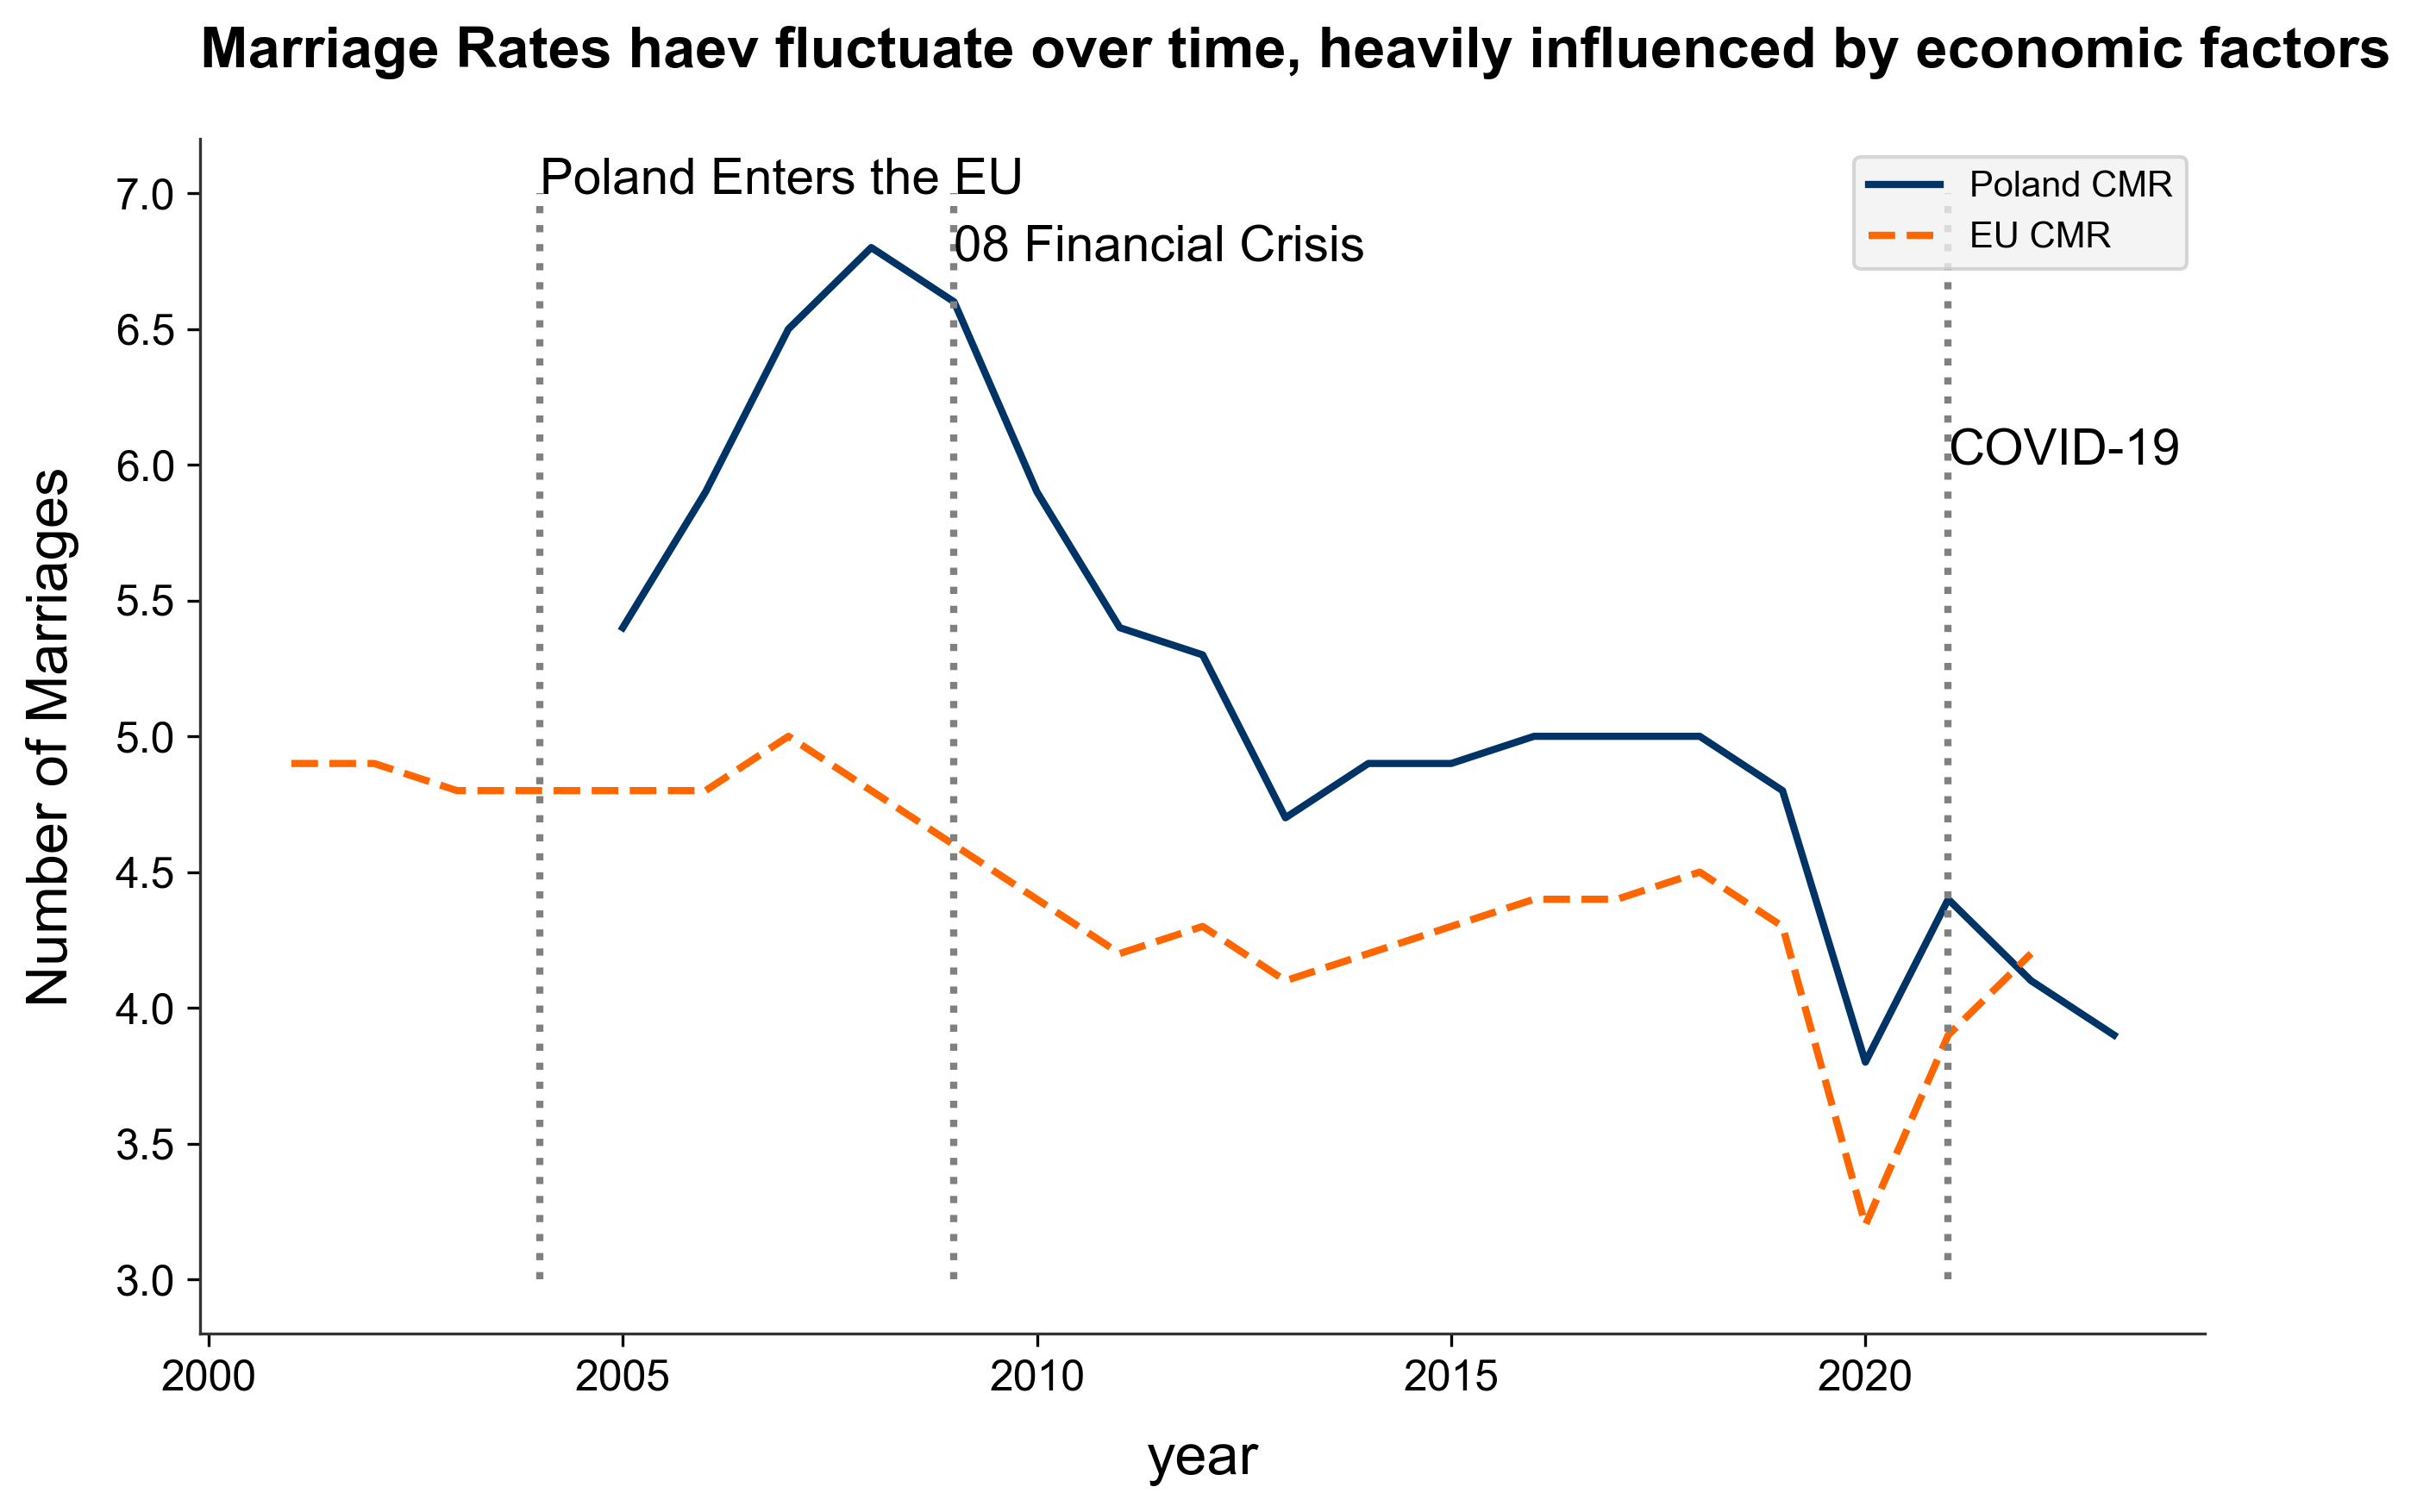

In [48]:

plt.figure(figsize=(10,6))

# ----- Axis Setup ----- #
ax1 = plt.gca()
# ax2 = ax1.twinx()

# ----- Plots ----- #
sns.lineplot(df_cmr, x='year', y='cmr', label='Poland CMR', ax=ax1)
sns.lineplot(df_cmr, x ='year', y ='cmr eu', label= 'EU CMR', ax=ax1, linestyle='--')

# ----- Title Formatting ---- #
plt.title('Marriage Rates haev fluctuate over time, heavily influenced by economic factors', loc='left', ha='left')

# ----- Axis Formatting ----- #
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}K'.format(y/1000)))
ax1.set_ylabel(ylabel='Number of Marriages per 1000')
# ax2.set_ylabel(ylabel='Age of Marriage')

ax1.grid(False)
# ax2.grid(False)

# ----- Legend Formatting ----- #
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax2.get_legend().remove()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

events = [[2004,"Poland Enters the EU", 7], [2009,'08 Financial Crisis', 6.75], [2021, 'COVID-19', 6.0]]

for event in events:
    plt.vlines(event[0],3,7,'gray',':', label=event[1],)
    plt.text(x = event[0], y = event[2], s= event[1])

plt.show()

In [49]:
events = [[2004,"Poland Enters the EU"],[2008,'\'08 Finacial Crisis'],[2020, 'COVID-19']]

#### Ave Age of First Marriage

To get an accurate number for the average age at time of marriage, we will compute the weighted average using the number of marraiges contracted at each age. Other datasets have this information already formatted, but often start at 2011 only. using this method we can get the same metric starting from 1995.

In [50]:
df_sing_age.head(5)

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1995,0,NaN
1,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1996,0,NaN
2,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1997,0,NaN
3,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1998,0,NaN
4,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1999,0,NaN


In [51]:
# Correcting 'age' to be an integer
df_sing_age['age'] = df_sing_age['age'].str.lstrip('Y').astype(int)

# Calculating the weighted average
df_avg_age = df_sing_age.groupby(['TIME_PERIOD', 'sex']).apply(
    lambda x: (x['age'] * x['OBS_VALUE']).sum() / x['OBS_VALUE'].sum()
).round(1).reset_index(name='Weighted_Avg_Age')

df_avg_age.columns = ['year', 'gender', 'ave age']
df_avg_age.replace(to_replace={'F': 'female', 'M':'male'}, inplace=True)

df_avg_age.head(5)

,year,gender,ave age
0,1995,female,22.5
1,1995,male,24.9
2,1996,female,22.6
3,1996,male,25.0
4,1997,female,22.8


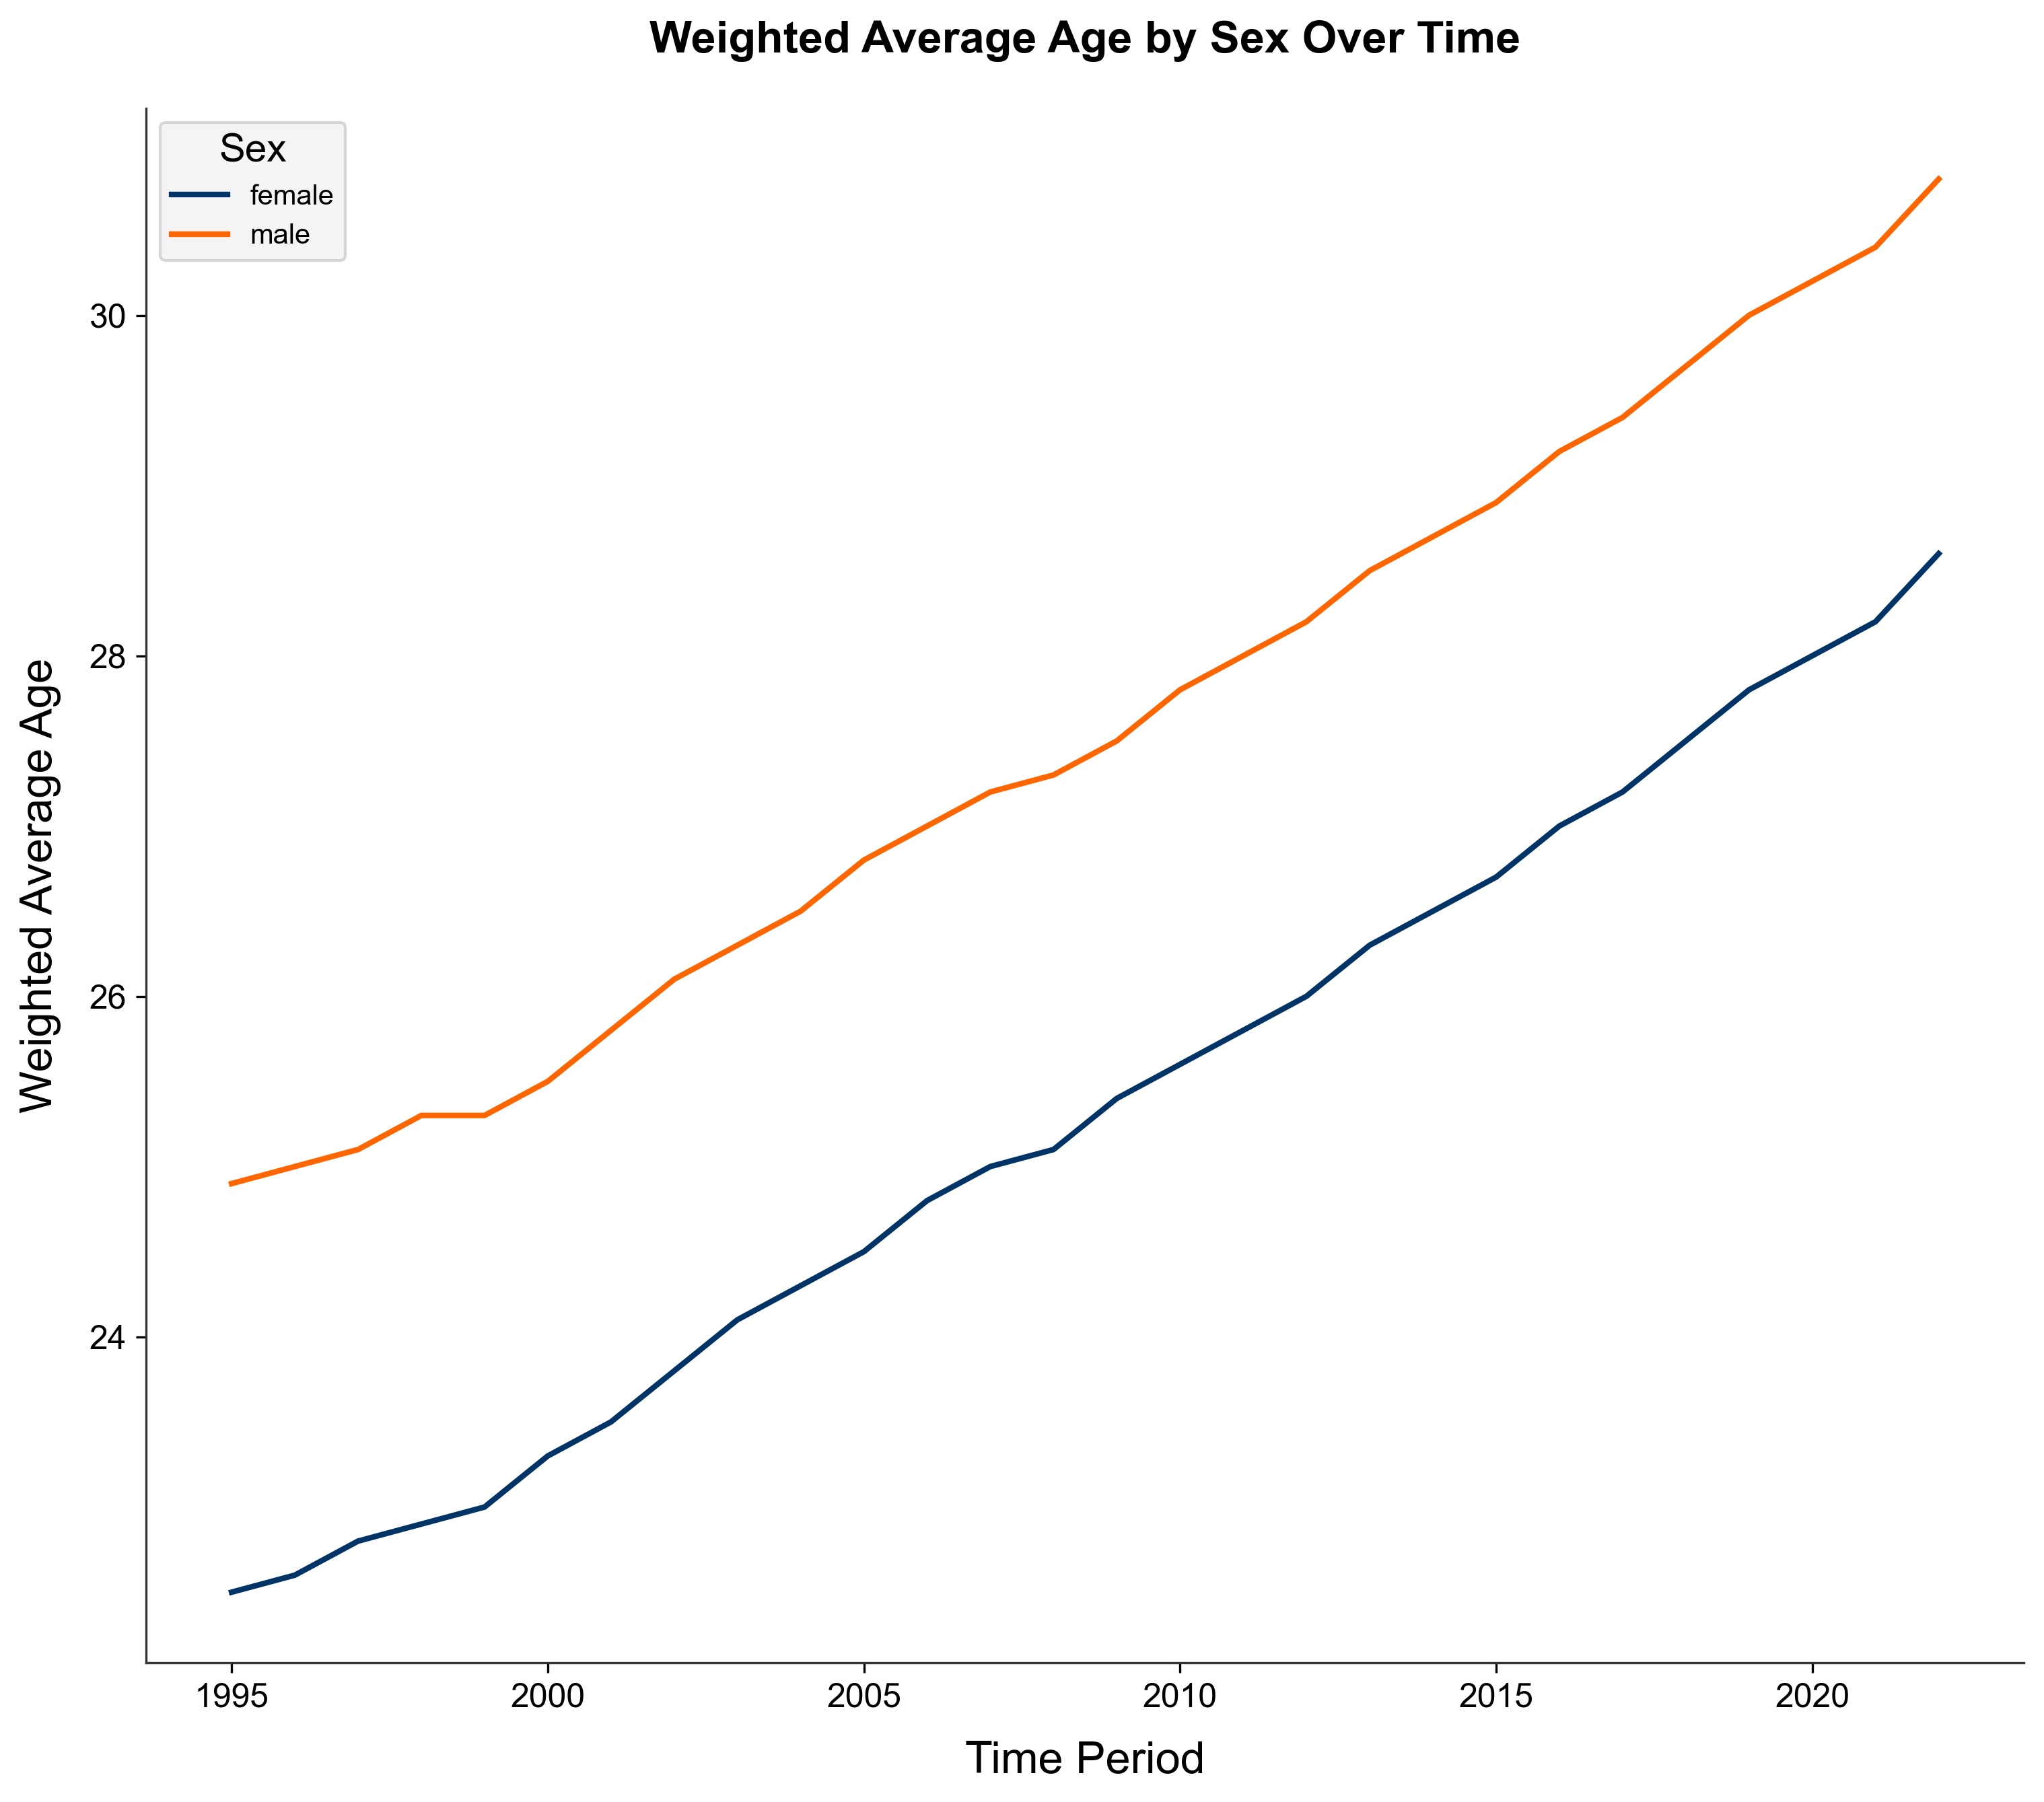

In [52]:
for gender in df_avg_age['gender'].unique():
    subset = df_avg_age[df_avg_age['gender'] == gender]
    plt.plot(subset['year'], subset['ave age'], label=gender)

# Adding labels and legend
plt.xlabel('Time Period')
plt.ylabel('Weighted Average Age')
plt.title('Weighted Average Age by Sex Over Time')
plt.legend(title='Sex')
plt.show()

In [53]:
## Exporting Dataframes for Dash app

if False:
    df_avg_age.to_csv(f'./data/dash_data/average_marriage_age.csv')
    df_cmr.to_csv(f'./data/dash_data/crude_marriage_rate.csv')
    df_marriage.to_csv(f'./data/dash_data/marriage_by_age_group.csv')
    # df_pop.to_csv(f'./data/dash_data/df_.csv')
    df_total_marriages.to_csv(f'./data/dash_data/total_marriages.csv')


___
# Plotly Dash
___

In [54]:
from dash import Dash, html, dash_table, dcc, callback, Input, Output
import plotly.express as px


ModuleNotFoundError: No module named 'dash'

In [1039]:
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize the Dash app
app = Dash(__name__)


# Define the app layout
app.layout = html.Div(style={'background':'white'},children=[
    html.H1('Marriages in Poland by Age Group and Gender'),
    dcc.Tabs( id='main-tab', value='tab-total-marriages', children=[
        dcc.Tab(label='Total Marriages', value='tab-total-marriages'),
        dcc.Tab(label='Ave Age of Couple', value='tab-ave-age'),
        dcc.Tab(label='Marriages by Age Group', value='tab-age-groups'),
    ]

    ),
    # dcc.Store(id='graph-ready', data=False),  # Hidden div to track graph readiness
    # html.Div(id='tabs-content-graph'),
    dcc.Loading(
    id="loading",
    type="default",
    children=html.Div(id='tabs-content-graph'),
    style={'display': 'none'}  # Hides loading spinner
)

])

# Callback on selecting a tab

@app.callback(
    Output('tabs-content-graph','children'),
    Input('main-tab','value')
)
def render_html(tab_value):

    if tab_value == 'tab-total-marriages':

        html_element = html.Div(children=[
                                html.H3('Total Marriages by Year'),
                                dcc.Dropdown(
                                    id='total-category-selector',
                                    options=[
                                        {'label': 'Total Marriages', 'value': 'total'},
                                        {'label': 'Crude Marriage Rate', 'value': 'cmr'}
                                    ],
                                    value='total',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Dropdown(
                                    id='show-eu-cmr',
                                    options=[
                                        {'label': 'Show EU CMR', 'value': 'eu-cmr'},
                                        {'label': 'Hide EU CMR', 'value': 'no-eu-cmr'}
                                    ],
                                    value='eu-cmr',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Graph(id='tab-1-main-content'
                                )],
                                style={'padding': '50px'}
                                )
    elif tab_value == 'tab-ave-age':
        html_element = html.Div(children=[
                                html.H3('Ave Age of Bride and Grooms'),
                                dcc.Graph(id='tab-2-main-content')
                                ]
                                )
    elif tab_value == 'tab-age-groups':
        html_element = html.Div(children=[
                                html.H3('Number of Marriages by Age Group & Year'),
                                dcc.Dropdown(
                                    id='group-category-selector',
                                    options=[
                                        {'label': 'Total Marriages', 'value': 'total'},
                                        {'label': '% of Total Marraiges', 'value': 'per-total'}
                                    ],
                                    value='total',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Dropdown(
                                    id='gender-selector',
                                    options=[
                                        {'label': 'Women', 'value': 'female'},
                                        {'label': 'Men', 'value': 'male'},
                                        {'label': 'Both', 'value': 'both'}
                                    ],
                                    value='both',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Graph(id='tab-3-main-content')
                                ]
                                )
    return html_element

# If CMR is selected show EU CMR Option

@app.callback(
    Output('show-eu-cmr', 'style'),
    [Input('total-category-selector', 'value'),
    Input('show-eu-cmr', 'style')]
)
def toggle_eu_cmr_visibility(selected_value, current_style):
    if current_style is None:
        current_style = {}
    current_style = current_style.copy()  # Make a copy to avoid mutating the original state

    if selected_value != 'cmr':
        current_style['display'] = 'none'
    else:
        current_style['display'] = 'block'
    
    return current_style

# Render Graph for Tab 1
@app.callback(
    Output('tab-1-main-content','figure'),
    [Input('total-category-selector','value'),
    Input('show-eu-cmr','value'),
    Input('main-tab','value')]
)
def tab_one_total_plots(total_type_value, cmr_value, tab_val):
    # if tab_val != 'tab-total-marriages':
    #     return
    fig = make_subplots(specs=[[{"secondary_y": False}]])

    if total_type_value == 'total':
        df=df_total_marriages
        fig.add_trace(go.Scatter(x=df['Year'], y=df['Value'], name="Count of Marriages"), secondary_y=False,)
        return fig

    elif total_type_value == 'cmr':
        df=df_cmr
        fig.add_trace(go.Scatter(x=df['year'], y=df['cmr'], name="CMR of PL"), secondary_y=False,)

    if cmr_value == 'eu-cmr':
        df=df_eu_cmr
        fig.add_trace(go.Scatter(x=df['year'], y=df['cmr'], name="CMR of EU"), secondary_y=False,)
    return fig

# Render Graph for Tab 2
@app.callback(
    Output('tab-2-main-content','figure'),
    Input('main-tab','value'),
)
def tab_two_average_age_graph(tab_value):

    fig = make_subplots(specs=[[{"secondary_y": False}]])

    df = df_ama_female[df_ama_female['gender'] == 'female']
    fig.add_trace(go.Scatter(x=df['year'], y=df['ave_age'], name="Ave Bride Age"), secondary_y=False,)

    df = df_ama_female[df_ama_female['gender'] == 'male']
    fig.add_trace(go.Scatter(x=df['year'], y=df['ave_age'], name="Ave Groom Age"), secondary_y=False,)

    return fig  

@app.callback(
    Output('tab-3-main-content','figure'),
    [Input('main-tab','value'),
     Input('group-category-selector','value'),
     Input('gender-selector','value')]
)
def tab_three_graphs(tab_value, group_value, gender_value):

    if gender_value == 'both':
        fig = make_subplots(rows=1, cols=2, subplot_titles=['men', 'women'])
        if group_value == 'total':

            df = df_female[df_female['age of bride'] != 'females total']

            for age_group in df['age of bride'].unique():
                df_temp = df[df['age of bride'] == age_group]
                fig.add_trace(go.Scatter(x=df_temp['Year'], y=df_temp['Value'], mode='lines', name=age_group), row=1, col=1)
            
            df = df_male[df_male['age of groom'] != 'males total']

            for age_group in df['age of groom'].unique():
                df_temp = df[df['age of groom'] == age_group]
                fig.add_trace(go.Scatter(x=df_temp['Year'], y=df_temp['Value'], mode='lines', name=age_group), row=1, col=2)

            return fig
        else:
            return fig
        
    else:
        fig = go.Figure()

    return fig




    

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', 
                   port=8050, 
                   dev_tools_ui=True, 
                   dev_tools_hot_reload=True, 
                   threaded=True
                   )


In [1040]:
from dash import Dash, html, dcc, Input, Output, State
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize the Dash app
app = Dash(__name__)


# Define the app layout
app.layout = html.Div(style={'background':'white'}, children=[
    html.H1('Marriages in Poland by Age Group and Gender'),
    dcc.Tabs( id='main-tab', value='tab-total-marriages', children=[
        dcc.Tab(label='Total Marriages', value='tab-total-marriages'),
        dcc.Tab(label='Ave Age of Couple', value='tab-ave-age'),
        dcc.Tab(label='Marriages by Age Group', value='tab-age-groups'),
    ]
    ),
    dcc.Loading(
    id="loading",
    type="default",
    children=html.Div(id='tabs-content-graph'),
    style={'display': 'none'}  # Hides loading spinner
    )

])

# Callback on selecting a tab

@app.callback(
    Output('tabs-content-graph','children'),
    Input('main-tab','value')
)
def render_html(tab_value):
    
    if tab_value == 'tab-total-marriages':

        html_element = html.Div(children=[
                                html.H3('Total Marriages by Year'),
                                dcc.Dropdown(
                                    id='total-category-selector',
                                    options=[
                                        {'label': 'Total Marriages', 'value': 'total'},
                                        {'label': 'Crude Marriage Rate', 'value': 'cmr'}
                                    ],
                                    value='total',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Dropdown(
                                    id='show-eu-cmr',
                                    options=[
                                        {'label': 'Show EU CMR', 'value': 'eu-cmr'},
                                        {'label': 'Hide EU CMR', 'value': 'no-eu-cmr'}
                                    ],
                                    value='eu-cmr',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Graph(id='tab-1-main-content'
                                )],
                                style={'padding': '50px'}
                                )
        
    elif tab_value == 'tab-ave-age':
        html_element = html.Div(children=[
                                html.H3('Ave Age of Bride and Grooms'),
                                dcc.Graph(id='tab-2-main-content')
                                ]
                                )
        
    elif tab_value == 'tab-age-groups':
        html_element = html.Div(children=[
                                html.H3('Number of Marriages by Age Group & Year'),
                                dcc.Dropdown(
                                    id='group-category-selector',
                                    options=[
                                        {'label': 'Total Marriages', 'value': 'total'},
                                        {'label': '% of Total Marraiges', 'value': 'per-total'}
                                    ],
                                    value='total',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Dropdown(
                                    id='gender-selector',
                                    options=[
                                        {'label': 'Women', 'value': 'female'},
                                        {'label': 'Men', 'value': 'male'},
                                        {'label': 'Both', 'value': 'both'}
                                    ],
                                    value='both',
                                    style={'width': '48%', 'display': 'inline-block', 'margin-right': '4%'}
                                ),
                                dcc.Graph(id='tab-3-main-content')
                                ]
                                )
    return html_element

# If CMR is selected show EU CMR Option

@app.callback(
    Output('show-eu-cmr', 'style'),
    [Input('total-category-selector', 'value'),
    Input('show-eu-cmr', 'style')]
)
def toggle_eu_cmr_visibility(selected_value, current_style):
    if current_style is None:
        current_style = {}
    current_style = current_style.copy()  # Make a copy to avoid mutating the original state

    if selected_value != 'cmr':
        current_style['display'] = 'none'
    else:
        current_style['display'] = 'block'
    
    return current_style

# Render Graph for Tab 1
@app.callback(
    Output('tab-1-main-content', 'figure'),
    [Input('total-category-selector', 'value'),
    Input('show-eu-cmr', 'value'),
    Input('main-tab', 'value')]
)
def tab_one_total_plots(total_type_value, cmr_value, tab_val):

    fig = make_subplots(specs=[[{"secondary_y": False}]])

    if total_type_value == 'total':
        df=df_total_marriages
        fig.add_trace(go.Scatter(x=df['Year'], y=df['Value'], name="Count of Marriages"), secondary_y=False,)
        return fig

    elif total_type_value == 'cmr':
        df=df_cmr.loc[:,['year','cmr']]
        fig.add_trace(go.Scatter(x=df['year'], y=df['cmr'], name="CMR of PL"), secondary_y=False,)

        if cmr_value == 'eu-cmr':
            df=df_cmr.loc[:,['year', 'cmr eu']]
            fig.add_trace(go.Scatter(x=df['year'], y=df['cmr eu'], name="CMR of EU"), secondary_y=False,)
    
    return fig

# Render Graph for Tab 2
@app.callback(
    Output('tab-2-main-content','figure'),
    Input('main-tab','value'),
)
def tab_two_average_age_graph(tab_value):

    fig = make_subplots(specs=[[{"secondary_y": False}]])

    for gender in df_ama_female['gender'].unique():
        df = df_ama_female[df_ama_female['gender'] == gender]
        fig.add_trace(go.Scatter(x=df['year'], y=df['ave_age'], name=f"Ave age of {gender}"), secondary_y=False)

    return fig

@app.callback(
    Output('tab-3-main-content', 'figure'),
    [Input('main-tab', 'value'),
     Input('group-category-selector', 'value'),
     Input('gender-selector', 'value')]
)
def tab_three_graphs(tab_value, group_value, gender_value):

    if gender_value == 'both':
        fig = make_subplots(rows=1, cols=2, subplot_titles=['men', 'women'])
        if group_value == 'total':

            for i, gender in enumerate(df_marriage['gender'].unique(),1):
                for age_group in df_marriage['age group'].unique():
                    df_temp = df_marriage[(df_marriage['age group'] == age_group) & (df_marriage['gender'] == gender )]
                    fig.add_trace(go.Scatter(x=df_temp['Year'], y=df_temp['Value'], mode='lines', name=f'{age_group} {gender}'), row=1, col=i)
                
            return fig
        else:
            return fig
        
    else:
        fig = go.Figure()

    return fig




    

# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline', 
                   port=8050, 
                   debug=True,
                   dev_tools_ui=True, 
                   dev_tools_hot_reload=True, 
                   threaded=True
                   )
